# Comparing Explainability Methods Under a White Box Model
This is a "fluorescent test," conducted under laboratory conditions with fluorescent lighting. In this test, we will generate synthetic data with known dynamics for the response variable. Next, we will calculate global explanations using various explainability methods and compare them against the ground truth.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

from explainer_comparison.ExplainerFactory import ExplainerFactory
from explainer_comparison.explainer_utilities import run_and_collect_explanations
from explainer_comparison.white_box_model.white_box import WhiteBoxRegressor
from explainer_comparison.explainers_evaluation import evaluate_explainers, permutation_feature_importance, plot_feat_importance


import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


In [2]:
# import sys
# sys.path

## Generate a White-Box Model and Data

In [3]:
# model = WhiteBoxRegressor()
# df = model.generate_synthetic_data(n_samples=1000, with_y=True)
# X, y = df.drop(['y'], axis=1), df[['y']]

In [4]:
n_samples = 1000
n_features = 10
feature_columns = [f'f_{i+1}' for i in range(n_features)]

X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_features, noise=0, random_state=42)
X = pd.DataFrame(X, columns=feature_columns)
y = pd.DataFrame(y, columns=['target'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Visualize Features and Target

<Axes: >

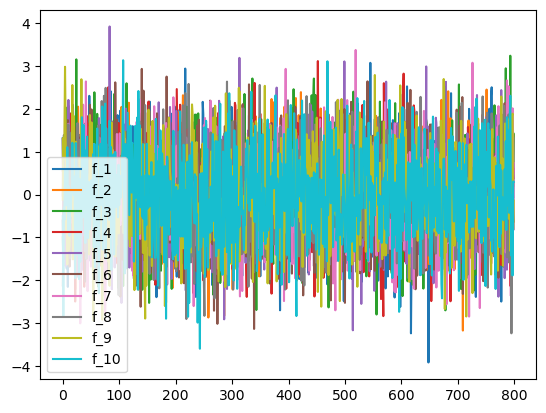

In [7]:
X_train.plot()

<Axes: >

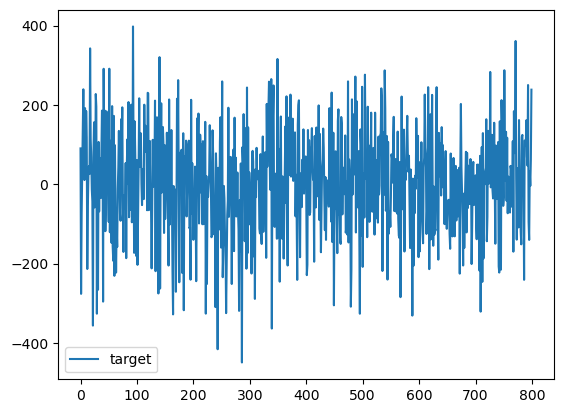

In [8]:
y_train.plot()

## Calculate SHAP and LIME explanation and Compare to Ground Truth

In [9]:
explainer_factory = ExplainerFactory(model, X_train, X_test, y_train, y_test)
results = run_and_collect_explanations(explainer_factory, X_train)
results['ground_truth'] = (X_train * model.coef_).mean()


 SHAP explanation created

 LIME explanation created

 EBM explanation created


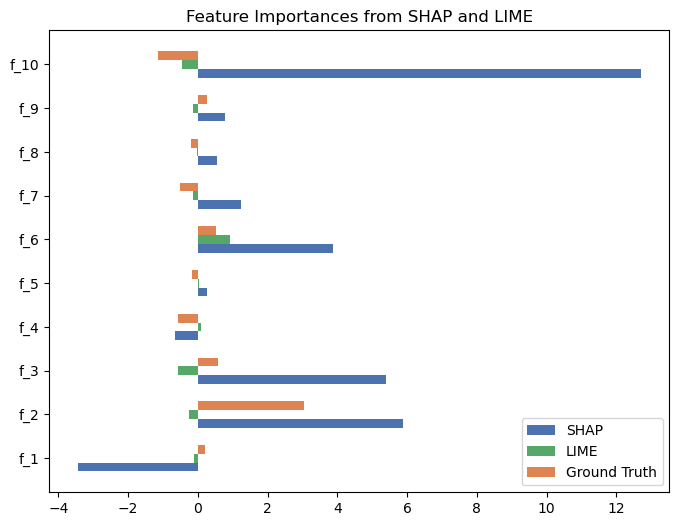

In [10]:
colors = sns.color_palette("deep")
plt.figure(figsize=(8, 6))

bar_positions = np.arange(len(results))  # Positions of the bars
bar_width = 0.2  # Adjust bar width to fit all bars

# Plotting the bars with adjusted positions
plt.barh(bar_positions - bar_width, results['SHAP Value'], height=bar_width, label='SHAP', color=colors[0])  # SHAP values
plt.barh(bar_positions, results['LIME Value'], height=bar_width, label='LIME', color=colors[2])  # LIME values
plt.barh(bar_positions + bar_width, results['ground_truth'], height=bar_width, label='Ground Truth', color=colors[1])  # Ground Truth values

plt.yticks(bar_positions, results.index)  #labels

plt.title('Feature Importances from SHAP and LIME')
plt.legend()
plt.show()

## Calculate permutation feature importance

In [9]:
feature_importances = permutation_feature_importance(model, X_test, random_state=42)

feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False, key=abs)

feature_importances_df

,importance
f_10,-2.273737e-15
f_9,-1.847411e-15
f_7,-1.705303e-15
f_1,-1.136868e-15
f_2,-1.136868e-15
f_8,-9.947598e-16
f_4,-8.526513e-16
f_6,-5.684342e-16
f_5,-5.062617e-16
f_3,0.000000e+00


## Feature elimination

In [10]:
# get results of feature elimination for different explainers

results_shap = evaluate_explainers(model, X_test, y_test, explainer='shap', threshold=0.3, random_state=42, verbose=False)#['shap', 'lime', 'ebm'])
results_lime = evaluate_explainers(model, X_test, y_test, explainer='lime', threshold=0.3, random_state=42, verbose=False)
results_permutation = evaluate_explainers(model, X_test, y_test, explainer='permutation', threshold=0.3, random_state=42, verbose=False)
results_ebm = evaluate_explainers(model, X_test, y_test, explainer='ebm', threshold=0.3, random_state=42, verbose=False)

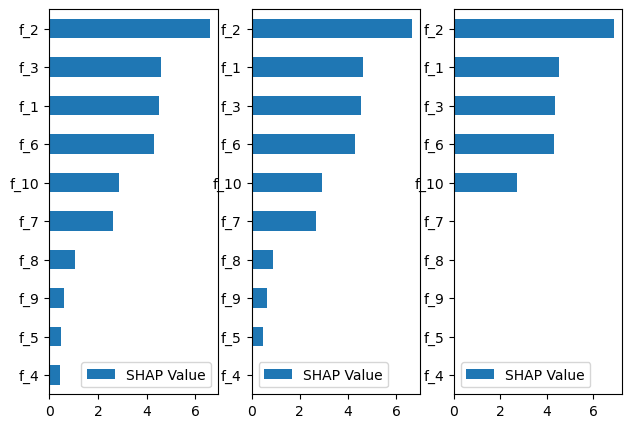

In [38]:
plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 4, 1)
abs(results_shap[0]).sort_values(by=results_shap[0].columns[0], key=abs).plot(kind='barh', ax=ax)

ax = plt.subplot(1, 4, 2)
abs(results_shap[1]).sort_values(by=results_shap[1].columns[0], key=abs).plot(kind='barh', ax=ax)

ax = plt.subplot(1, 4, 3)
abs(results_shap[5]).sort_values(by=results_shap[5].columns[0], key=abs).plot(kind='barh', ax=ax)

plt.show()

In [36]:
results_shap

[      SHAP Value
 f_1     4.505649
 f_2    -6.603986
 f_3    -4.589519
 f_4    -0.442141
 f_5     0.466635
 f_6     4.308876
 f_7    -2.615803
 f_8    -1.039163
 f_9    -0.608533
 f_10   -2.861167,
       SHAP Value
 f_1     4.619710
 f_2    -6.652815
 f_3    -4.521468
 f_5     0.484287
 f_6     4.301249
 f_7    -2.680148
 f_8    -0.885637
 f_9    -0.628924
 f_10   -2.905869
 f_4     0.000000,
       SHAP Value
 f_1     4.672027
 f_2    -6.654544
 f_3    -4.487027
 f_6     4.303803
 f_7    -2.714037
 f_8    -0.982850
 f_9    -0.638412
 f_10   -2.891570
 f_4     0.000000
 f_5     0.000000,
       SHAP Value
 f_1     4.750508
 f_2    -6.589246
 f_3    -4.468216
 f_6     4.247632
 f_7    -2.870902
 f_8    -0.981873
 f_10   -2.893508
 f_4     0.000000
 f_5     0.000000
 f_9     0.000000,
       SHAP Value
 f_1     4.769912
 f_2    -6.617850
 f_3    -4.411594
 f_6     4.296555
 f_7    -2.888803
 f_10   -2.894356
 f_4     0.000000
 f_5     0.000000
 f_9     0.000000
 f_8     0.000000,
     

In [33]:
# Store sorted data for later use
sorted_data_list = []
for df in results_shap:
    sorted_data = df.abs().sort_values(by=df.columns[0], key=abs)
    sorted_data_list.append(sorted_data)

# Function to plot specific data frames
def plot_specific_dfs(indexes):
    plt.figure(figsize=(10, len(indexes) * 5))
    for i, idx in enumerate(indexes, 1):
        ax = plt.subplot(len(indexes), 1, i)
        sorted_data_list[idx].plot(kind='barh', ax=ax)
        ax.set_title(f'Feature Importance for DataFrame {idx + 1}')
    plt.tight_layout()
    plt.show()


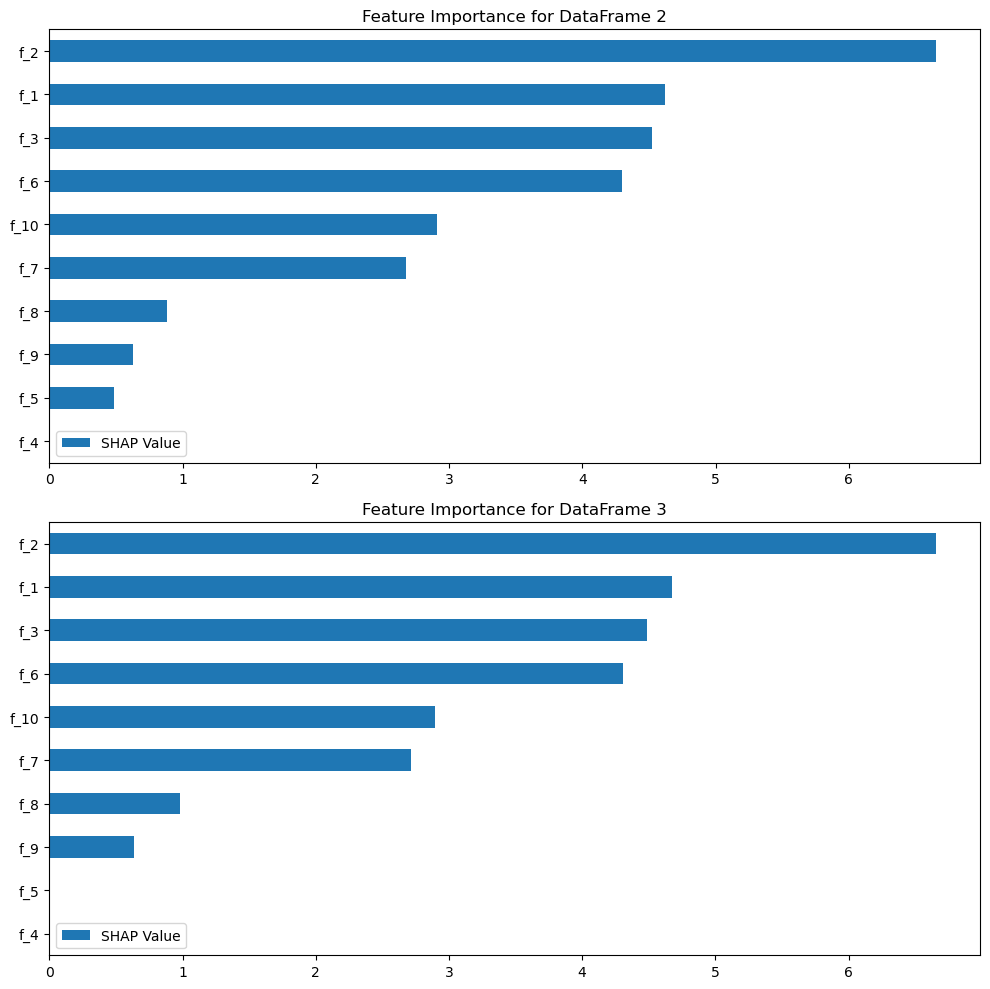

In [34]:
plot_specific_dfs([1, 2])

The least_important_feature is f_4


<Figure size 200x300 with 0 Axes>

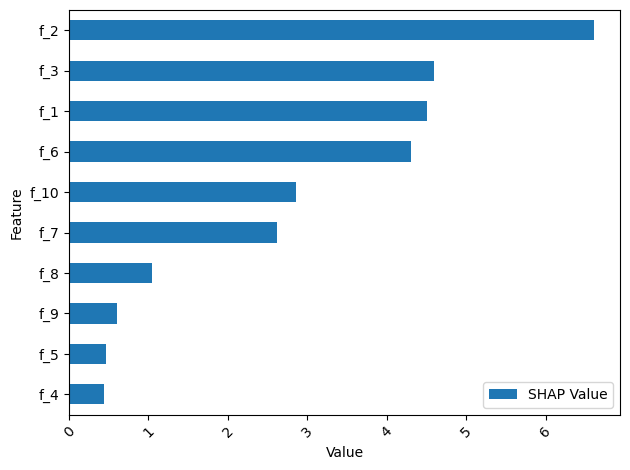

The least_important_feature is f_5


<Figure size 200x300 with 0 Axes>

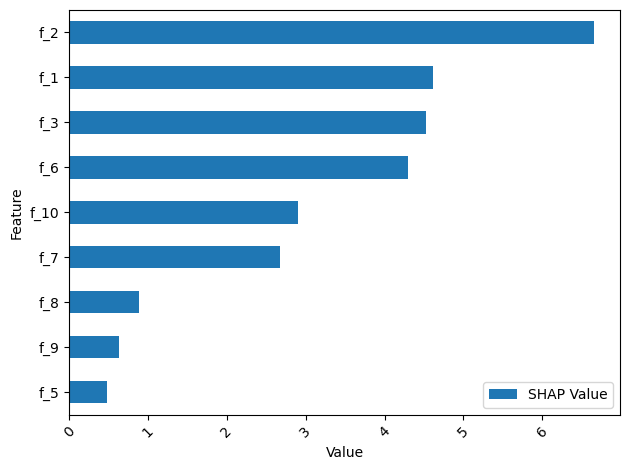

The least_important_feature is f_9


<Figure size 200x300 with 0 Axes>

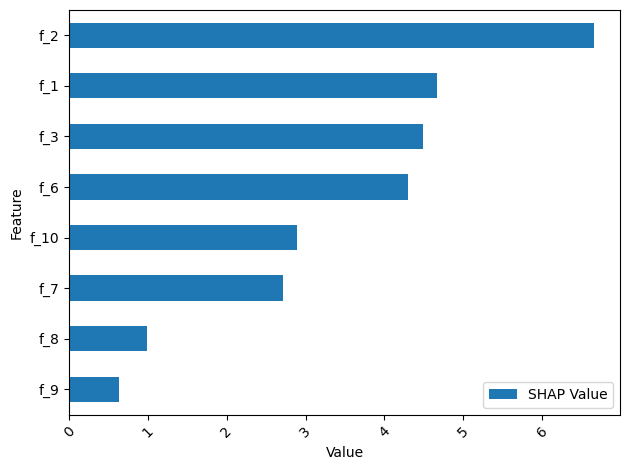

The least_important_feature is f_8


<Figure size 200x300 with 0 Axes>

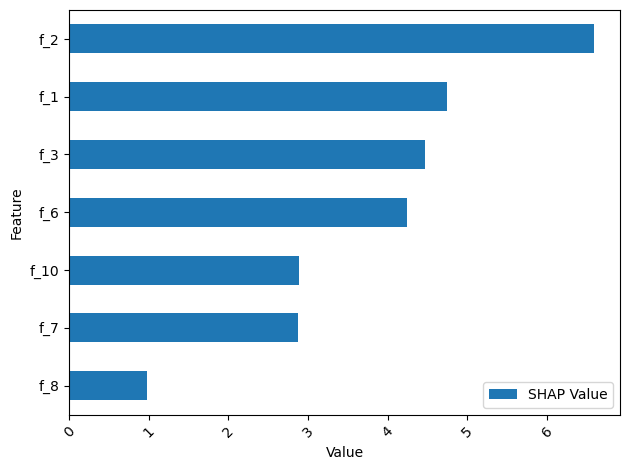

The least_important_feature is f_7


<Figure size 200x300 with 0 Axes>

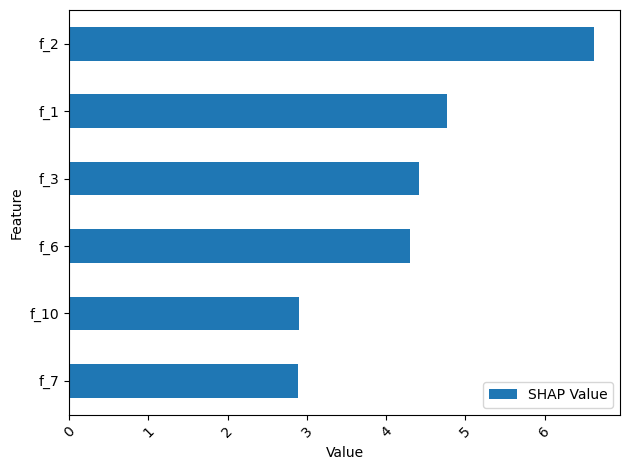

The least_important_feature is f_10


<Figure size 200x300 with 0 Axes>

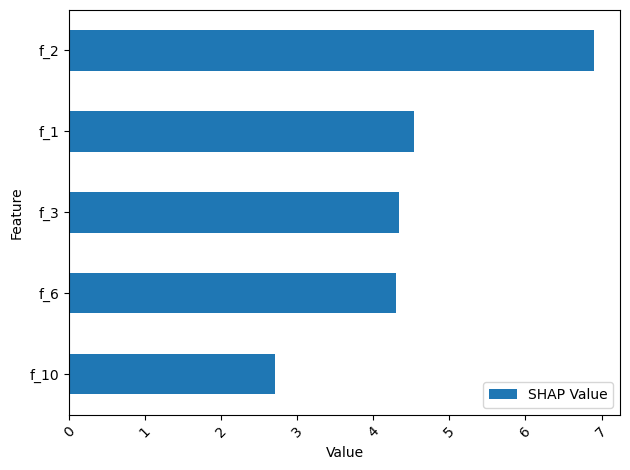

The least_important_feature is f_3


<Figure size 200x300 with 0 Axes>

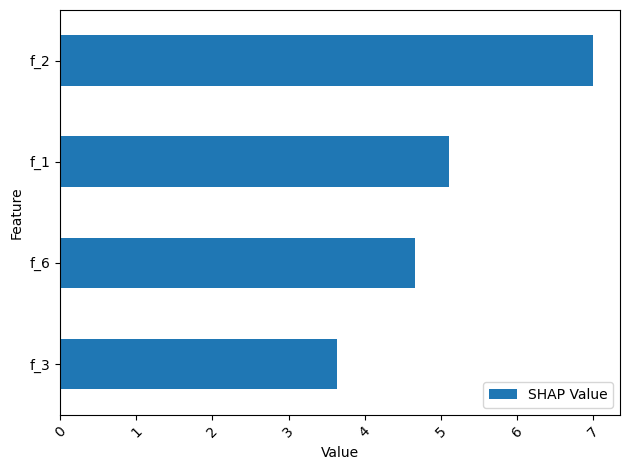

In [13]:
for rdf in results:
    plot_feat_importance(rdf)

In [18]:
abs(results[0])

,SHAP Value
f_1,4.505649
f_2,6.603986
f_3,4.589519
f_4,0.442141
f_5,0.466635
f_6,4.308876
f_7,2.615803
f_8,1.039163
f_9,0.608533
f_10,2.861167


<Axes: >

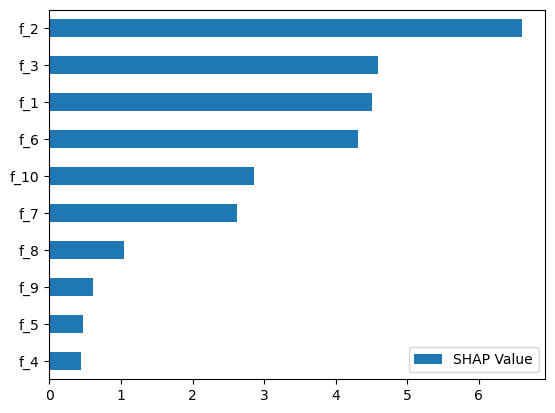

In [19]:
abs(results[0]).sort_values(by=results[0].columns[0], key=abs).plot(kind='barh')